<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/vae/vae-mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE による画像生成

VAE（Variational Autoencoder、変分オートエンコーダ）は、データを「圧縮」し、そしてその圧縮されたデータから元のデータに似たものを「生成」できるように設計されたモデルです。大きな画像を少ない次元で表現できるのです。

### 1. データの圧縮（低次元空間での表現）

VAEでは、元のデータ（例えば28x28ピクセルの画像）を低次元空間と呼ばれる小さな数値の集合で表現します。この低次元空間は、「データの本質的な特徴」だけを保持したシンプルな表現です。例えば、「手書き数字の形」を捉えた2次元や3次元の点として表現することができます。

今回の実験では、手書き数字画像データセット「MNIST」を使います。このデータセットには、0から9までの手書き数字（28x28ピクセル）の画像が含まれています。VAEを用いてこれらの画像を圧縮し、28×28の784次元から、たった数次元の潜在空間に情報を収める仕組みを確認します。

### 2. データの生成（解凍）

圧縮されたデータ（潜在変数）をもとに、元のようなデータを再び作り出すことを「生成」と呼びます。VAEは、この潜在変数から、新しいデータを生成できる点が特徴です。潜在変数は、「手書き数字」を表現する低次元空間の中の点です。この空間のどこかに新しい点を1つ取れば、それを元にして新しい手書き数字を作り出すことができます。

MNISTを用いた今回の実験では、潜在変数の空間からランダムに点を選び、そこから生成される手書き数字を観察します。また、潜在空間を2次元に設定しているので、数字ごとの分布を視覚化し、圧縮された特徴がどのように学習されているかを確認できます。

## 演習

それでは、ライブラリのインストールから進めていきましょう。
事前に GPU ランタイムを設定してください。

In [ ]:
# 必要なライブラリをインストール
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNISTデータセットのロード
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.36MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.35MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### MNISTデータセットを観察する

まず、手書き数字データセット「MNIST」に含まれる画像を観察してみます。MNISTは、0から9までの手書き数字が28x28ピクセルのグレースケール画像として収められたデータセットです。

とりあえず、それぞれの数字（0～9）を1枚ずつ取得し、横に並べて表示してみます。

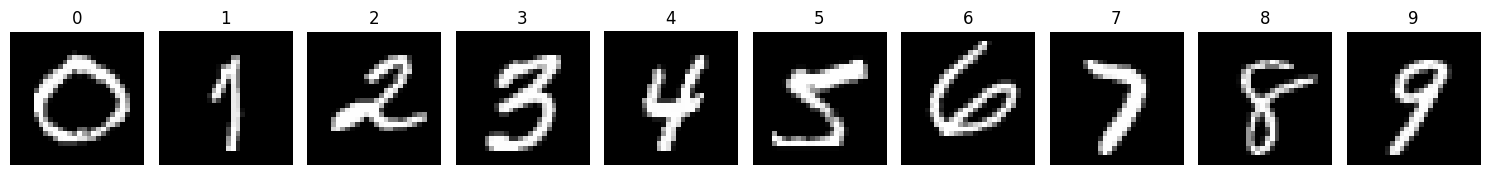

In [ ]:
# 数字ごとの画像を1枚ずつ取得
digit_images = [None] * 10  # 0から9までの数字用
for images, labels in train_loader:
    for i in range(len(labels)):
        digit = labels[i].item()
        if digit_images[digit] is None:
            digit_images[digit] = images[i].squeeze(0)  # 画像データを保存
        if all(img is not None for img in digit_images):  # 全ての数字の画像が揃ったら終了
            break
    if all(img is not None for img in digit_images):  # 全ての数字の画像が揃ったら終了
        break

# 横に並べて表示
fig, ax = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    ax[i].imshow(digit_images[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(str(i))
plt.tight_layout()
plt.show()

### ネットワーク構造

VAE（Variational Autoencoder）を構築するためのPyTorchモデル ConvVAE を示します。以下のような2つの主要な部分で構成されています。

- **エンコーダ（Encoder）**

    入力画像  (1,28,28)  を畳み込み層で処理し、低次元の潜在空間（latent space）に変換します。この変換は、潜在変数 z を求めるときに平均 (μ) と分散 (log⁡σ2) を用います。

- **デコーダ（Decoder）**

    潜在変数 z をもとに、転置畳み込み（逆畳み込み）層を使用して、潜在空間から画像の形状を再構築します。

#### ネットワークの主要なステップ


- Decoder

    潜在変数 z を全結合層と転置畳み込み層を用いて、元の画像サイズに戻します。

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        # Encoder部分の定義
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 畳み込み層1: 入力 (B, 1, 28, 28) -> 出力 (B, 32, 14, 14)
            nn.ReLU(),  # 活性化関数: 非線形性を導入
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 畳み込み層2: (B, 32, 14, 14) -> (B, 64, 7, 7)
            nn.ReLU(),  # 活性化関数
            nn.Flatten()  # Flatten: 畳み込みの出力を1次元ベクトルに変換 (B, 64*7*7)
        )
        # 潜在変数の平均 (mu) を計算する全結合層
        self.fc_mu = nn.Linear(64 * 7 * 7, 2)  # 平均: 出力次元は潜在変数の次元 (ここでは2)
        # 潜在変数の対数分散 (logvar) を計算する全結合層
        self.fc_logvar = nn.Linear(64 * 7 * 7, 2)  # 対数分散: 出力次元は潜在変数の次元 (ここでは2)

        # Decoder部分の定義
        # 潜在変数zを全結合層で元のFlattenされた形式に戻す
        self.fc_z = nn.Linear(2, 64 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),  # 1次元ベクトルを元の形状に戻す (B, 64*7*7) -> (B, 64, 7, 7)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 転置畳み込み層1: (B, 64, 7, 7) -> (B, 32, 14, 14)
            nn.ReLU(),  # 活性化関数
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 転置畳み込み層2: (B, 32, 14, 14) -> (B, 1, 28, 28)
            nn.Sigmoid()  # 出力を0~1の範囲に正規化
        )

    # エンコーダ部分: 入力画像を潜在変数の平均と分散に変換
    def encode(self, x):
        h1 = self.encoder(x)  # 畳み込みとFlattenで特徴を抽出
        return self.fc_mu(h1), self.fc_logvar(h1)  # 平均と分散を計算

    # 再パラメータ化トリック: 潜在変数zを生成
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # 分散を標準偏差に変換
        eps = torch.randn_like(std)  # 正規分布から乱数を生成
        return mu + eps * std  # 潜在変数z = 平均 + 標準偏差 * 乱数

    # デコーダ部分: 潜在変数zから元の画像を再構築
    def decode(self, z):
        h3 = self.fc_z(z)  # 潜在変数を全結合層でFlattenの形状に戻す
        return self.decoder(h3)  # 転置畳み込みを用いて元の画像サイズに変換

    # 順伝播: 入力画像を潜在変数zを通して再構築
    def forward(self, x):
        mu, logvar = self.encode(x)  # エンコーダで平均と分散を計算
        z = self.reparameterize(mu, logvar)  # 再パラメータ化トリックで潜在変数を生成
        return self.decode(z), mu, logvar  # 再構築画像、平均、分散を返す


### **損失関数**
VAEの損失関数は、次の2つの項から構成されています：

1. **再構築誤差（Binary Cross Entropy, BCE）**  
   元の入力画像とモデルが再構築した画像のピクセル単位の誤差を表します。この誤差を小さくすることで、モデルが元の画像に近いデータを生成する能力を向上させます。

   - 各ピクセルの確率分布（0～1の値）に基づき、元の画像と再構築画像がどれだけ一致しているかを計算します。
   - 数式で表すと次のようになります：  
     \[
     BCE = - \sum \left( x \cdot \log(\hat{x}) + (1 - x) \cdot \log(1 - \hat{x}) \right)
     \]

2. **KLダイバージェンス（Kullback-Leibler Divergence, KLD）**  
   エンコーダによって学習された潜在分布（\( q(z|x) \)）が、標準正規分布（\( p(z) \)）にどれだけ近いかを測ります。これにより、潜在空間を正規化し、生成されたデータの多様性が向上します。

   - 数式で表すと次のようになります：  
     \[
     KLD = - \frac{1}{2} \sum \left( 1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right)
     \]

### **最終的な損失**
損失は、再構築誤差（BCE）とKLダイバージェンス（KLD）の合計で計算されます：
\[
\text{Loss} = \text{BCE} + \text{KLD}
\]
これにより、モデルは元のデータを正確に再構築しつつ、潜在空間の構造を規則化します。


In [ ]:
# 損失関数
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


### **学習ループ**
学習ループでは、以下のプロセスを繰り返します：

1. **ミニバッチごとにデータを取得**  
   データセットを分割して少量のデータ（ミニバッチ）を順に取り出します。これにより、大規模なデータセットを効率的に学習できます。

2. **データをデバイスに転送**  
   モデルと同じデバイス（GPU）にデータを移動します。

3. **モデルの出力を計算**  
   入力データをモデルに通し、再構築画像（recon_batch）、潜在変数の平均（\(\mu\)）、分散の対数（\(\log \sigma^2\)）を取得します。

4. **損失関数を計算**  
   再構築誤差（BCE）とKLダイバージェンス（KLD）を用いて損失を計算します。

5. **勾配を計算し、モデルを更新**  
   損失に基づいて勾配を計算（逆伝播）し、オプティマイザを使ってモデルのパラメータを更新します。

6. **損失を記録**  
   各エポックでの平均損失を計算し、学習の進捗をモニタリングします。


In [ ]:
# モデルの初期化
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 学習ループ
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 195.9026
Epoch 2, Loss: 169.0297
Epoch 3, Loss: 164.5978
Epoch 4, Loss: 161.5095
Epoch 5, Loss: 159.4577
Epoch 6, Loss: 158.0350
Epoch 7, Loss: 157.0017
Epoch 8, Loss: 156.2754
Epoch 9, Loss: 155.5467
Epoch 10, Loss: 155.0789


### 潜在変数から画像を生成

それでは任意の潜在変数ベクトル（例えば \([-0.6, 1.2]\)）をデコーダに入力し、そこから生成された画像を観察します。

#### 何をするのか？
1. **潜在空間に任意の点を指定**  
   潜在空間の中から1つの点（ベクトル）を選びます。このベクトルは、潜在変数の値を指定するためのもので、-3 から 3 くらいまでの範囲で自由に決めることができます。

2. **選んだ点から画像を生成**  
   デコーダを使い、この点が表現する画像を生成します。潜在空間の中の点がどのようなデータ（例えば手書き数字）を表現しているかを観察できます。

#### どのようなことがわかるのか？
潜在空間の値を変更することで、生成される画像がどのように変化するかを確認できます。これにより、潜在空間の各次元がデータにどのような意味を持つのか（例えば数字の形、角度、太さなど）を直感的に理解することができます。

この関数 `generate_image_from_latent` を使って、任意の潜在変数から画像を生成し、その結果を可視化してみましょう。


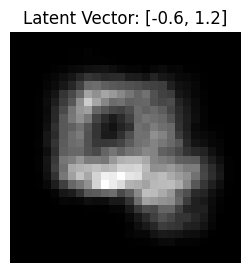

In [ ]:
def generate_image_from_latent(latent_vector, model, device):
    """
    潜在変数ベクトルから画像を生成して表示する関数

    Args:
        latent_vector (list or np.ndarray): 潜在変数のリストまたは配列 [z0, z1]
        model (torch.nn.Module): 学習済みのVAEモデル
        device (torch.device): モデルのデバイス（CPU or GPU）
    """
    model.eval()  # 評価モードに設定
    with torch.no_grad():
        # 潜在変数をテンソルに変換し、デバイスに送る
        z = torch.tensor([latent_vector], device=device, dtype=torch.float32)
        # 潜在変数から生成された画像を取得
        generated_image = model.decode(z).cpu().numpy().reshape(28, 28)

    # 画像を表示
    plt.figure(figsize=(3, 3))
    plt.imshow(generated_image, cmap="gray")
    plt.title(f"Latent Vector: {latent_vector}")
    plt.axis("off")
    plt.show()

# 使用例
generate_image_from_latent([-0.6, 1.2], model, device)


### **潜在空間の可視化**

VAEの特徴のひとつは、潜在空間におけるデータの分布を学習し、その空間から新しいデータを生成できることです。このステップでは、学習された潜在空間を2次元の格子点として可視化します。

具体的には：
1. 潜在空間の範囲を \([-3, 3]\) とし、この範囲内の格子点を生成します。
2. 各格子点を潜在変数 \( z \) としてデコーダに入力し、生成された画像を可視化します。
3. この可視化により、潜在空間内の異なる位置がどのようなデータ（画像）を表現しているかを直感的に理解できます。

図の横軸と縦軸は、それぞれ潜在空間の \( z \) の第1次元（横軸）と第2次元（縦軸）それぞれ -3 から 3 までの結果を示します。

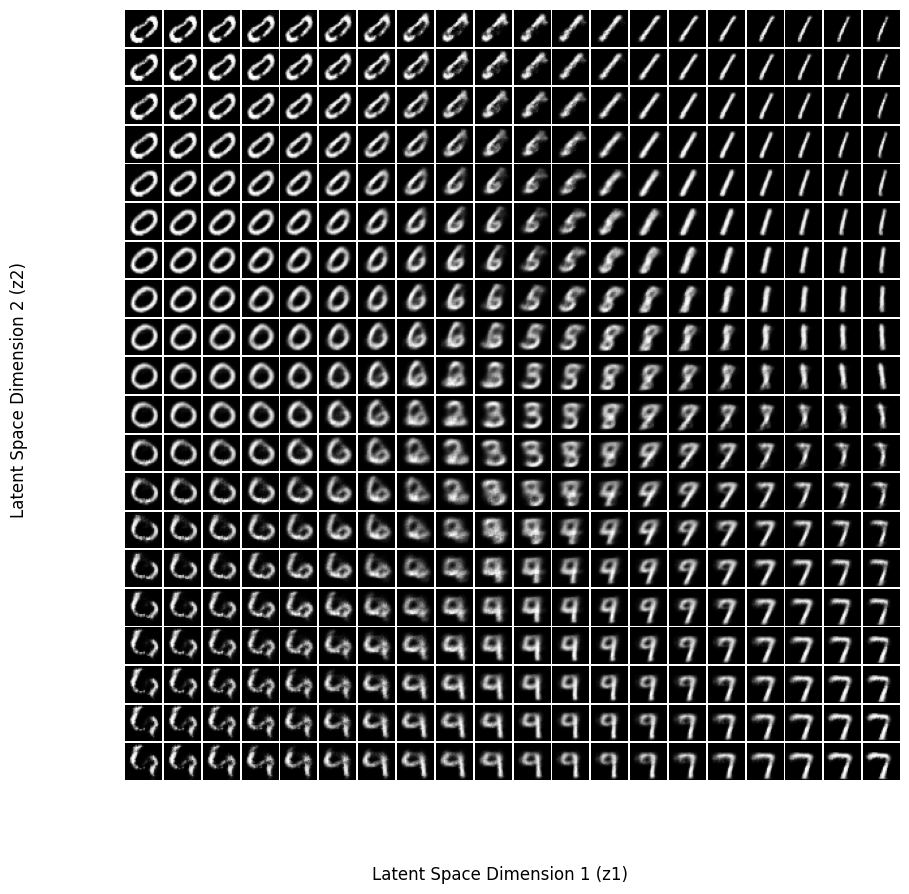

In [ ]:
# 潜在空間を可視化
model.eval()
x_vals = np.arange(-3, 3, 0.3)  # 潜在空間の横軸（第1次元）の範囲と刻み幅
y_vals = np.arange(-3, 3, 0.3)  # 潜在空間の縦軸（第2次元）の範囲と刻み幅

fig, ax = plt.subplots(len(y_vals), len(x_vals), figsize=(10, 10))  # 画像全体のサイズを調整

# 潜在空間上の格子点をループして画像を生成
for i, yi in enumerate(y_vals):
    for j, xi in enumerate(x_vals):
        z = torch.tensor([[xi, yi]], device=device, dtype=torch.float32)  # 格子点を潜在変数zとして設定

        with torch.no_grad():  # 勾配を計算せずに推論モードでデコーダを実行
            sample = model.decode(z).cpu().numpy()  # 生成された画像をNumPy形式に変換
        ax[i, j].imshow(sample.reshape(28, 28), cmap="gray")  # 画像をグリッドに表示
        ax[i, j].axis("off")  # 軸目盛りを非表示にする

# 軸と数値ラベルの設定
for i, yi in enumerate(y_vals):
    ax[i, 0].set_ylabel(f"{yi:.1f}", fontsize=6, labelpad=2)  # 縦軸に数値ラベルを追加
for j, xi in enumerate(x_vals):
    ax[-1, j].set_xlabel(f"{xi:.1f}", fontsize=6, labelpad=2)  # 横軸に数値ラベルを追加

# グラフ全体のラベルを追加
fig.text(0.5, 0.01, "Latent Space Dimension 1 (z1)", ha="center", fontsize=12)  # 横軸ラベル
fig.text(0.01, 0.5, "Latent Space Dimension 2 (z2)", va="center", rotation="vertical", fontsize=12)  # 縦軸ラベル

plt.subplots_adjust(wspace=0.05, hspace=0.05)  # プロット間の余白を最小化
plt.show()
